In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_chisquare
import seaborn as sns

In [83]:
raw = pd.read_csv("Index2018.csv")
df_comp = raw.copy()
df_comp.date = pd.to_datetime(raw.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method="ffill")

In [84]:
df_comp['market_value'] = df_comp.ftse

In [85]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## ADF Test for stationarity

In [86]:
results = sts.adfuller(df.market_value)
print(f"T-statistics: {results[0]}")
print(f"P-value: {results[1]}")
print(f"Number of lags used in the regression when determine the t-statistics: {results[2]}")
print(f"T-statistics level of significance: {results[4]}")

T-statistics: -1.9041551418836873
P-value: 0.330108932770283
Number of lags used in the regression when determine the t-statistics: 6
T-statistics level of significance: {'1%': -3.4316548765428174, '5%': -2.8621166146845334, '10%': -2.5670769326348926}


Fail to reject null hypothesis since the P-value $>0.05$ (accept $H_0$, the data is non-stationary)

## Using Returns

In [87]:
df['return'] = df.market_value.pct_change(1)

<ipython-input-87-46df085ba4c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'] = df.market_value.pct_change(1)


In [88]:
results = sts.adfuller(df['return'].dropna())
print(f"T-statistics: {results[0]}")
print(f"P-value: {results[1]}")
print(f"Number of lags used in the regression when determine the t-statistics: {results[2]}")
print(f"T-statistics level of significance: {results[4]}")

T-statistics: -12.770265719497003
P-value: 7.798058336046944e-24
Number of lags used in the regression when determine the t-statistics: 32
T-statistics level of significance: {'1%': -3.431661944885779, '5%': -2.8621197374408225, '10%': -2.5670785949998973}


## ACF and PACF Plot

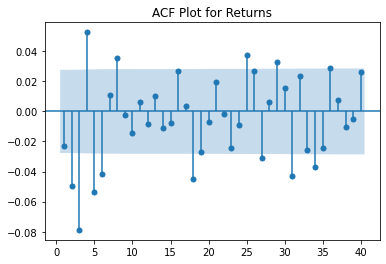

In [89]:
sgt.plot_acf(df['return'].dropna(), lags=40, zero=False)
plt.title("ACF Plot for Returns")
plt.show()

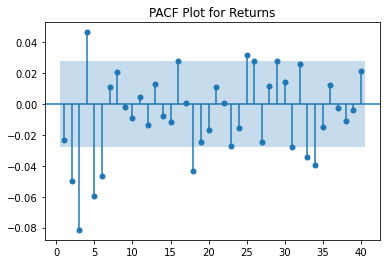

In [90]:
sgt.plot_pacf(df['return'].dropna(), lags=40, zero=False)
plt.title("PACF Plot for Returns")
plt.show()

## Fitting AR(1) on the Returns

In [91]:
returns = df['return'].dropna().astype(float)

In [92]:
model_ar_1 = ARIMA(returns, order = (1,0,0))
result_1 = model_ar_1.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               15188.206
Date:                Wed, 18 Nov 2020   AIC                         -30370.411
Time:                        22:23:41   BIC                         -30350.848
Sample:                    01-10-1994   HQIC                        -30363.556
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.139      0.255      -0.000       0.001
ar.L1         -0.0230      0.009     -2.698      0.007      -0.040      -0.006
sigma2         0.0001   1.38e-06    100.100      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Both p-values are $>0.05$ thus they are non-significance to 0. This model has no predictive power.

The more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes. This is due to the compounding error effects.

## Higher-lag AR Models for Returns

Runs until LLR $>= 0.005$. <br>
Lower LLR value (<=0.05) means that the results of model 1 and model 2 is significance different to each other. <br>
On the other hand, higher LLR (>0.05) means that model is insignificance to each other.

In [93]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [94]:
model_ar_2 = ARIMA(returns, order = (2,0,0))
result_2 = model_ar_2.fit()
print(result_2.summary())
print("\nLLR Test P-value = " + str(LLR_test(model_ar_1, model_ar_2)))

                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               15194.499
Date:                Wed, 18 Nov 2020   AIC                         -30380.997
Time:                        22:23:42   BIC                         -30354.912
Sample:                    01-10-1994   HQIC                        -30371.857
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.188      0.235      -0.000       0.000
ar.L1         -0.0242      0.009     -2.802      0.005      -0.041      -0.007
ar.L2         -0.0501      0.008     -6.373      0.0

In [95]:
for i in range(0,10):
    print("#"*20 + f"Comparing AR models with lag of {i} & {i+1}" +"#"*20 )
    model_1 = ARIMA(returns, order = (i,0,0))
    model_2 = ARIMA(returns, order = (i+1,0,0))
    result_2 = model_2.fit()
    print(result_2.summary())
    print("\nLLR Test P-value = " + str(LLR_test(model_1, model_2)))
    print("#"*80)

####################Comparing AR models with lag of 0 & 1####################
                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               15188.206
Date:                Wed, 18 Nov 2020   AIC                         -30370.411
Time:                        22:23:44   BIC                         -30350.848
Sample:                    01-10-1994   HQIC                        -30363.556
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.139      0.255      -0.000       0.001
ar.L1         -0.0230      0.009     -2.698      0.00

D:\anaconda3\envs\time-series-tutorials\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



LLR Test P-value = 0.103
################################################################################
####################Comparing AR models with lag of 1 & 2####################
                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               15194.499
Date:                Wed, 18 Nov 2020   AIC                         -30380.997
Time:                        22:23:47   BIC                         -30354.912
Sample:                    01-10-1994   HQIC                        -30371.857
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002    

D:\anaconda3\envs\time-series-tutorials\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                ARIMA(10, 0, 0)   Log Likelihood               15232.576
Date:                Wed, 18 Nov 2020   AIC                         -30441.151
Time:                        22:25:02   BIC                         -30362.897
Sample:                    01-10-1994   HQIC                        -30413.730
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.244      0.214      -0.000       0.000
ar.L1         -0.0245      0.009     -2.598      0.009      -0.043      -0.006
ar.L2         -0.0506      0.008     -6.181      0.0

D:\anaconda3\envs\time-series-tutorials\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



LLR Test P-value = 0.515
################################################################################


#### We choose AR(6) as our final model since it has more coefficient and lower P-value in LLR test compare to AR(7).

## Normalizing Values

In [96]:
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark).mul(100)
sts.adfuller(df['norm'])

<ipython-input-96-a7e44b696762>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm'] = df.market_value.div(benchmark).mul(100)


(-1.9041551418836287,
 0.3301089327703105,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 19541.17381480549)

In [97]:
bench_ret = returns.iloc[0]
df['norm_ret'] = df['return'].div(bench_ret).mul(100)
sts.adfuller(df['norm_ret'].dropna())

<ipython-input-97-b810c63d89f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_ret'] = df['return'].div(bench_ret).mul(100)


(-12.770265719497306,
 7.798058336035753e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124897)

### Find the best model for Normalized Return

In [98]:
norm_returns = df['norm_ret'].dropna()
for i in range(0,10):
    print("#"*20 + f"Comparing AR models with lag of {i} & {i+1}" +"#"*20 )
    model_1 = ARIMA(norm_returns, order = (i,0,0))
    model_2 = ARIMA(norm_returns, order = (i+1,0,0))
    result_2 = model_2.fit()
    print(result_2.summary())
    print("\nLLR Test P-value = " + str(LLR_test(model_1, model_2)))
    print("#"*80)

####################Comparing AR models with lag of 0 & 1####################
                               SARIMAX Results                                
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -40351.743
Date:                Wed, 18 Nov 2020   AIC                          80709.487
Time:                        22:25:14   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.476     -1.143      0.253     -32.506       8.560
ar.L1         -0.0230      0.009     -2.697      0.00

We can observe that the normalized value does not affects the model selection. It does not impact the p-values or coefficients.

## Residuals Analysis

Extract the residuals for all models we believe to be good fits. Examine the summary of the statistics and test them for stationary.

In [103]:
#select the best model
model_ret_6 = ARIMA(returns, order = (6,0,0))
model_ret_6_result = model_ret_6.fit()

In [104]:
df["res_ret"] = model_ret_6_result.resid

<ipython-input-104-e23ce47cc7e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["res_ret"] = model_ret_6_result.resid


In [107]:
df.res_ret.mean()

2.803350315486689e-06

In [108]:
df.res_ret.var()

0.00013559803419416346

In [109]:
sts.adfuller(df.res_ret.dropna())

(-70.7693092104436,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 -30239.39848265406)

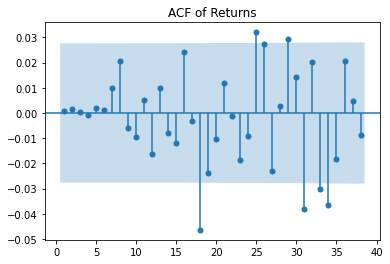

In [112]:
sgt.plot_acf(df.res_ret.dropna(), zero=False)
plt.title("ACF of Returns")
plt.show()

<AxesSubplot:xlabel='date'>

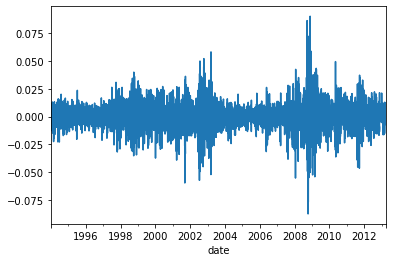

In [110]:
df.res_ret.plot()